# Data Processing

This notebook is for preparing the data for classical ML models

In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import torch
from torchvision.transforms import v2
from torch.utils.data import DataLoader
import pyarrow
import sys


sys.path.append('../src')
from datasets import StateFarmDD

%matplotlib inline

In [5]:
# Loading in the data labels
train_labels = pd.read_csv('../data/training.csv')
train_labels.head()

,subject,classname,img
0,p075,c5,img_75085.jpg
1,p035,c1,img_24344.jpg
2,p021,c4,img_58937.jpg
3,p022,c4,img_26388.jpg
4,p066,c9,img_33260.jpg


In [6]:
# Getting the classnames
classnames = train_labels.classname.unique().tolist()
classnames

['c5', 'c1', 'c4', 'c9', 'c7', 'c3', 'c0', 'c8', 'c2', 'c6']

(1, 500, 500)


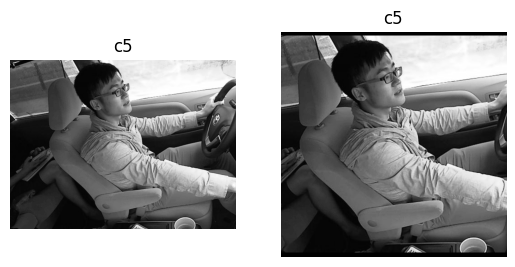

(1, 500, 500)


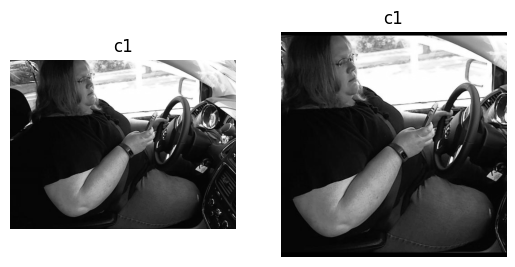

(1, 500, 500)


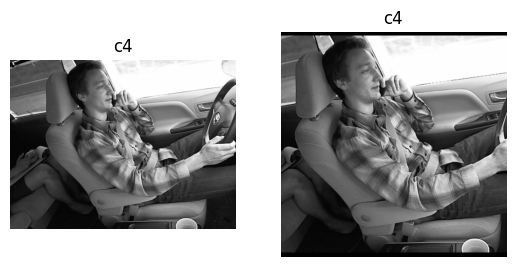

(1, 500, 500)


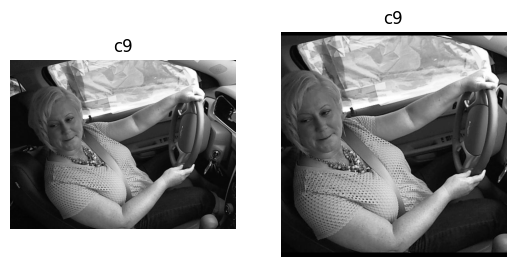

(1, 500, 500)


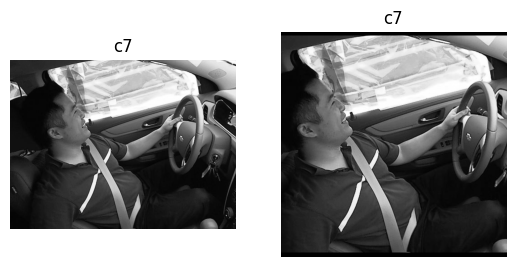

(1, 500, 500)


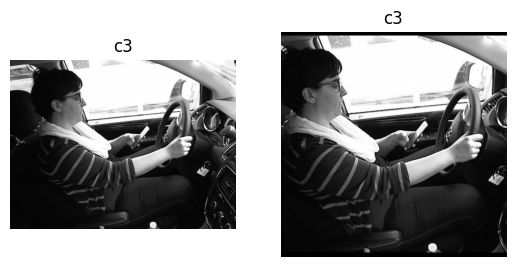

(1, 500, 500)


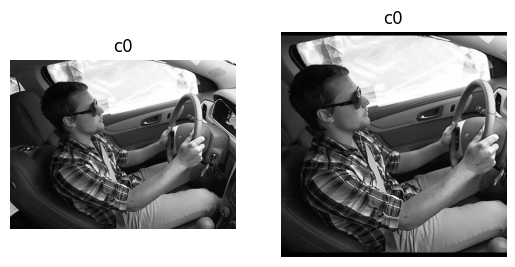

(1, 500, 500)


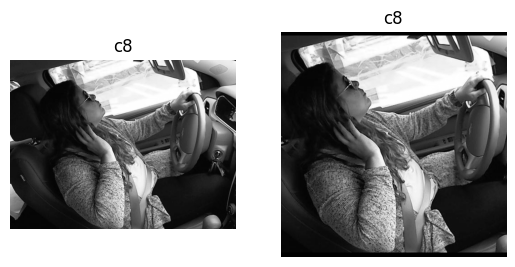

(1, 500, 500)


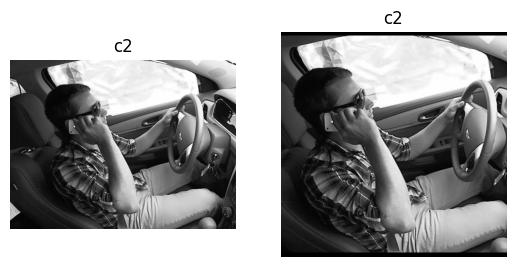

(1, 500, 500)


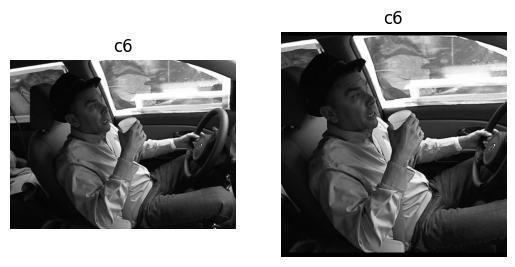

In [7]:
# Displaying a random image from each class
for classname in classnames:
    sample = train_labels[train_labels.classname == classname].sample(1)['img'].item()
    img = plt.imread(f'../data/imgs/train/{classname}/{sample}')
    # Converting image to grayscale
    img_tensor = torch.from_numpy(img.copy()).float()
    img_tensor = img_tensor.permute(2, 0, 1)
    grayscale_img = v2.Grayscale()(img_tensor).numpy()

    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(grayscale_img.squeeze(0), cmap='gray')
    ax1.set_title(classname)
    ax1.axis('off')

    # Plotting cropped image
    cropped_image = v2.CenterCrop(500)(torch.from_numpy(grayscale_img).float()).numpy()
    print(cropped_image.shape)
    ax2.imshow(cropped_image.squeeze(0), cmap='gray')
    ax2.set_title(classname)
    ax2.axis('off')
    plt.show()

In [8]:
# Building the Training Dataframe
transformation_pipeline = v2.Compose([
        v2.ToImage(),
        v2.Grayscale(),
        v2.CenterCrop(500),
])
training_dataset = StateFarmDD('../data/training.csv',transform_pipeline=transformation_pipeline)
training_dataloader = DataLoader(training_dataset, batch_size=len(training_dataset), shuffle=False)
x_train, y_train = next(iter(training_dataloader))
x_train = torch.flatten(x_train,start_dim=1).numpy()
y_train = y_train.numpy()

df = pd.DataFrame(x_train)
df['label'] = y_train
df.head()

,0,1,2,3,4,5,6,7,8,9,...,249991,249992,249993,249994,249995,249996,249997,249998,249999,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9


In [9]:
# Checking the shape
df.shape

(17939, 250001)

In [10]:
# Saving the dataframe in a parquet file
df.to_parquet('../data/train.parquet', engine='pyarrow',index=False)

In [11]:
validation_dataset = StateFarmDD('../data/validation.csv',transform_pipeline=transformation_pipeline)
validation_dataloader = DataLoader(validation_dataset, batch_size=len(validation_dataset), shuffle=False)
x_valid, y_valid = next(iter(validation_dataloader))
x_valid = torch.flatten(x_valid,start_dim=1).numpy()
y_valid = y_valid.numpy()

df = pd.DataFrame(x_valid)
df['label'] = y_valid
df.head()

,0,1,2,3,4,5,6,7,8,9,...,249991,249992,249993,249994,249995,249996,249997,249998,249999,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8


In [12]:
# Checking the shape
df.shape

(4485, 250001)

In [13]:
# Saving the dataframe in a parquet file
df.to_parquet('../data/valid.parquet', engine='pyarrow',index=False)